In [3]:
!pip install statsmodels


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import mysql.connector
import statsmodels.stats.api as sms
import statsmodels.api as sm
from scipy import stats as st

In [5]:
df_cust = pd.read_csv("dataset/customers.csv")
df_cust.head(10)

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
0,1,Dhruv Bansal,Female,2,City,Business Owner,358211.0,Married
1,2,Kabir Thakur,Female,47,City,Consultant,65172.0,Single
2,3,Kriti Mangal,Male,21,City,Freelancer,22378.0,Married
3,4,Sara Dwivedi,Male,24,Rural,Freelancer,33563.0,Married
4,5,Aarohi Negi,Male,48,City,Consultant,39406.0,Married
5,6,Aditi Kaul,Male,22,City,Freelancer,44887.0,Married
6,7,Aisha Mittal,Female,32,Suburb,Business Owner,259013.0,Married
7,8,Aarya Choudhary,Male,27,City,Freelancer,159400.0,Married
8,9,Simran Naidu,Male,21,Suburb,Fullstack Developer,34814.0,Single
9,10,Rishabh Bhat,Male,25,Rural,Freelancer,39832.0,Married


In [6]:


conn = mysql.connector.connect(
    host='localhost',
    user='root',
    passwd='r@@t0987',
    database='e_master_card'
)

df_cust = pd.read_sql("SELECT * FROM customers", conn)
df_cust.head(3)

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
0,1,Dhruv Bansal,Female,2,City,Business Owner,358211.0,Married
1,2,Kabir Thakur,Female,47,City,Consultant,65172.0,Single
2,3,Kriti Mangal,Male,21,City,Freelancer,22378.0,Married


In [7]:
df_trans = pd.read_sql("SELECT * FROM transactions", conn)
df_trans.head(3)

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
0,1,705,2023-01-01,63,Flipkart,Electronics,Phonepe
1,2,385,2023-01-01,99,Alibaba,Fashion & Apparel,Credit Card
2,3,924,2023-01-01,471,Shopify,Sports,Phonepe


In [8]:
df_cs = pd.read_sql("SELECT * FROM credit_profiles", conn)
df_cs.head(3)

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
0,1,749,0.585171,19571.0,0.0,40000.0
1,2,587,0.107928,161644.0,2.0,1250.0
2,3,544,0.854807,513.0,4.0,1000.0


# Treating null values

In [9]:
df_cust.describe()

,cust_id,age,annual_income
count,1000.000000,1000.000000,950.000000
mean,500.500000,36.405000,139410.314737
std,288.819436,15.666155,112416.802007
min,1.000000,1.000000,2.000000
25%,250.750000,26.000000,47627.500000
50%,500.500000,32.000000,112218.500000
75%,750.250000,46.000000,193137.500000
max,1000.000000,135.000000,449346.000000


In [10]:
df_cust.isnull().sum()

cust_id            0
name               0
gender             0
age                0
location           0
occupation         0
annual_income     50
marital_status     0
dtype: int64

In [11]:
df_cust[df_cust.annual_income.isna()].head(4) 

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
14,15,Isha Arora,Female,25,Rural,Artist,NaN,Married
82,83,Sanjana Singhal,Male,27,City,Freelancer,NaN,Single
97,98,Sia Batra,Male,47,Suburb,Business Owner,NaN,Married
102,103,Pooja Ganguly,Male,32,City,Data Scientist,NaN,Married


In [12]:
df_cust[df_cust.occupation=="Artist"].annual_income.median()

np.float64(45794.0)

In [13]:
occupation_wise_inc_median = df_cust.groupby("occupation")["annual_income"].median() 
occupation_wise_inc_median

occupation
Accountant              65265.0
Artist                  45794.0
Business Owner         261191.5
Consultant              58017.0
Data Scientist         135759.0
Freelancer              46759.0
Fullstack Developer     76774.0
Name: annual_income, dtype: float64

In [14]:
def get_median_val(row):
    if pd.isnull(row["annual_income"]):
        return occupation_wise_inc_median[row["occupation"]]
    else:
        return row["annual_income"]

In [15]:
get_median_val({"cust_id": 3245, "occupation": "Artist", "annual_income": 678})

678

In [16]:
df_cust["annual_income"] = df_cust.apply(
    lambda row: occupation_wise_inc_median[row["occupation"]] if pd.isnull(row["annual_income"]) else row["annual_income"] ,
    axis=1)

In [17]:
df_cust.isnull().sum()

cust_id           0
name              0
gender            0
age               0
location          0
occupation        0
annual_income     0
marital_status    0
dtype: int64

In [18]:
df_cust.iloc[[14,82]]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
14,15,Isha Arora,Female,25,Rural,Artist,45794.0,Married
82,83,Sanjana Singhal,Male,27,City,Freelancer,46759.0,Single


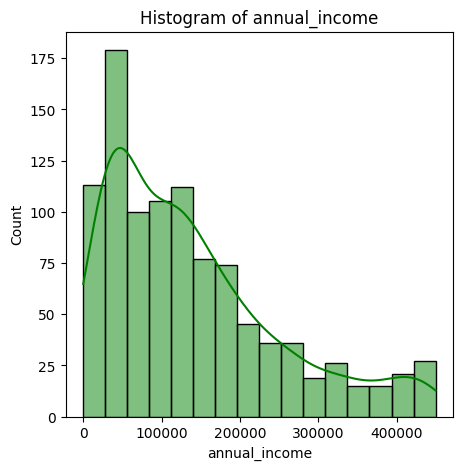

In [19]:
plt.figure(figsize=(5,5))
sns.histplot(df_cust['annual_income'], kde=True, color='green', label ='Data')
plt.title('Histogram of annual_income')
plt.show()

# Treating Outliers

In [20]:
df_cust[df_cust.annual_income<100]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
31,32,Veer Gambhir,Male,50,City,Business Owner,50.0,Married
262,263,Veer Rathod,Male,53,Suburb,Business Owner,50.0,Married
316,317,Avinash Chauhan,Male,47,City,Consultant,50.0,Married
333,334,Samaira D'Souza,Female,29,City,Data Scientist,50.0,Married
340,341,Ridhi Rastogi,Female,33,Rural,Fullstack Developer,50.0,Married
543,544,Gauri Gupta,Male,54,City,Consultant,2.0,Married
592,593,Vivaan Pande,Female,32,City,Business Owner,50.0,Married
633,634,Aradhya Pandey,Male,26,City,Data Scientist,2.0,Married
686,687,Gauri Nanda,Male,40,City,Business Owner,2.0,Married
696,697,Avani Lalwani,Male,47,City,Consultant,20.0,Married


In [21]:
occupation_wise_inc_median

occupation
Accountant              65265.0
Artist                  45794.0
Business Owner         261191.5
Consultant              58017.0
Data Scientist         135759.0
Freelancer              46759.0
Fullstack Developer     76774.0
Name: annual_income, dtype: float64

In [22]:
for index, row in df_cust.iterrows():
    if row ["annual_income"]<100:
        df_cust.at[index, "annual_income"] = occupation_wise_inc_median[row["occupation"]]
       

In [23]:
df_cust[df_cust.annual_income<100]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status


In [24]:
df_cust.loc[[31, 316]]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
31,32,Veer Gambhir,Male,50,City,Business Owner,261191.5,Married
316,317,Avinash Chauhan,Male,47,City,Consultant,58017.0,Married


# Data Visualization: Annual income

In [25]:
avg_income_per_occupation = df_cust.groupby("occupation")["annual_income"].mean()
avg_income_per_occupation

occupation
Accountant              64123.562500
Artist                  45309.236842
Business Owner         268447.368512
Consultant              60703.154639
Data Scientist         137021.266304
Freelancer              76327.508772
Fullstack Developer     78727.972973
Name: annual_income, dtype: float64

In [26]:
avg_income_per_occupation.index

Index(['Accountant', 'Artist', 'Business Owner', 'Consultant',
       'Data Scientist', 'Freelancer', 'Fullstack Developer'],
      dtype='object', name='occupation')

In [27]:
avg_income_per_occupation.values

array([ 64123.5625    ,  45309.23684211, 268447.36851211,  60703.15463918,
       137021.26630435,  76327.50877193,  78727.97297297])

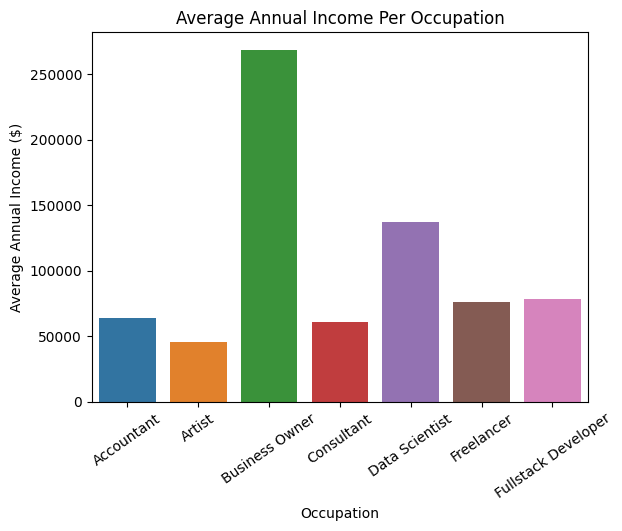

In [28]:
sns.barplot(x=avg_income_per_occupation.index, y = avg_income_per_occupation.values, palette="tab10")
plt.xticks(rotation=35)

plt.title("Average Annual Income Per Occupation")
plt.xlabel("Occupation")
plt.ylabel("Average Annual Income ($)")
plt.show() 

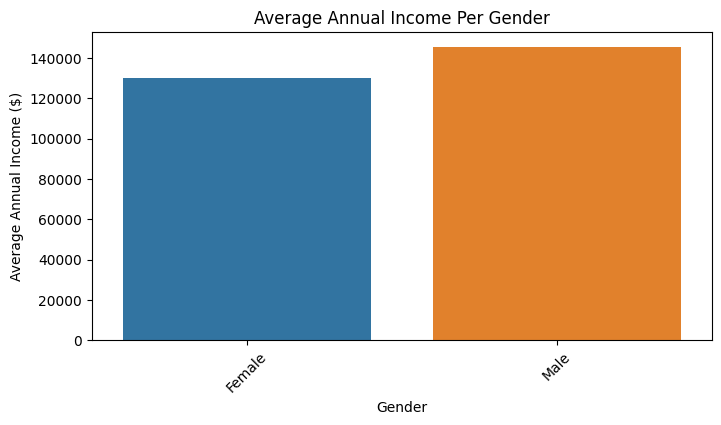

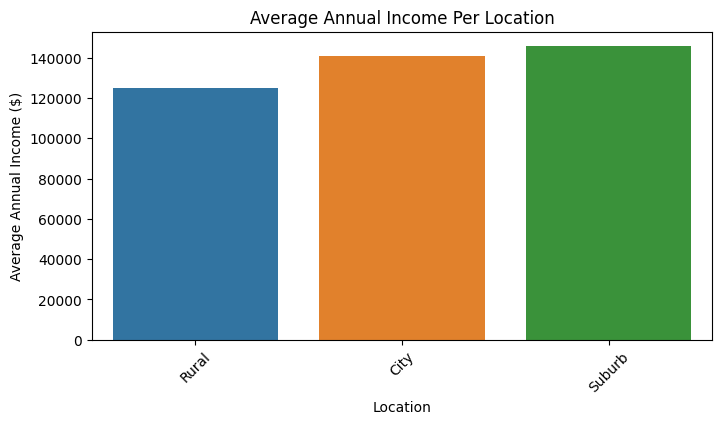

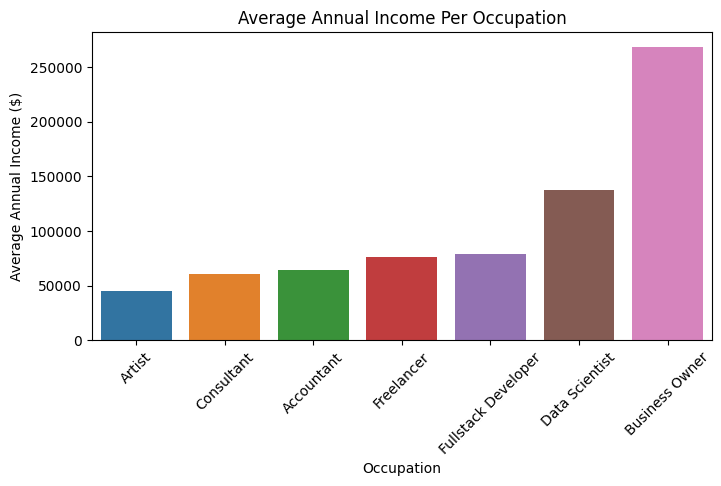

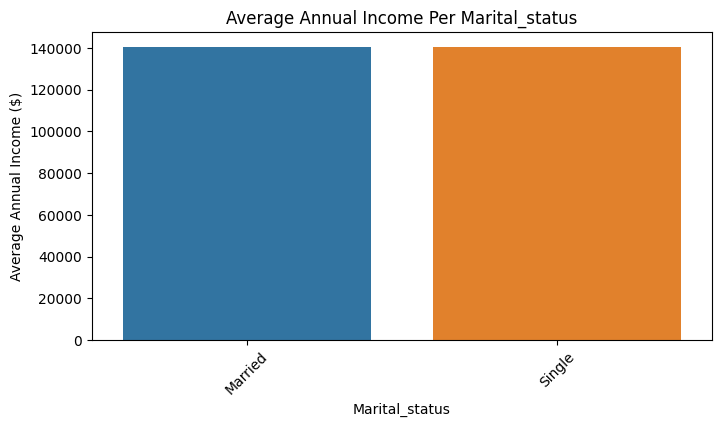

In [29]:
categorical_columns = ['gender', 'location', 'occupation', 'marital_status']

for col in categorical_columns:
    plt.figure(figsize=(8, 4))
    avg_income_per_group = df_cust.groupby(col)['annual_income'].mean().sort_values()
    sns.barplot(x=avg_income_per_group.index, y=avg_income_per_group.values, palette='tab10')
    plt.xticks(rotation=45)
    plt.title(f'Average Annual Income Per {col.capitalize()}')
    plt.xlabel(col.capitalize())
    plt.ylabel('Average Annual Income ($)')
    plt.show()

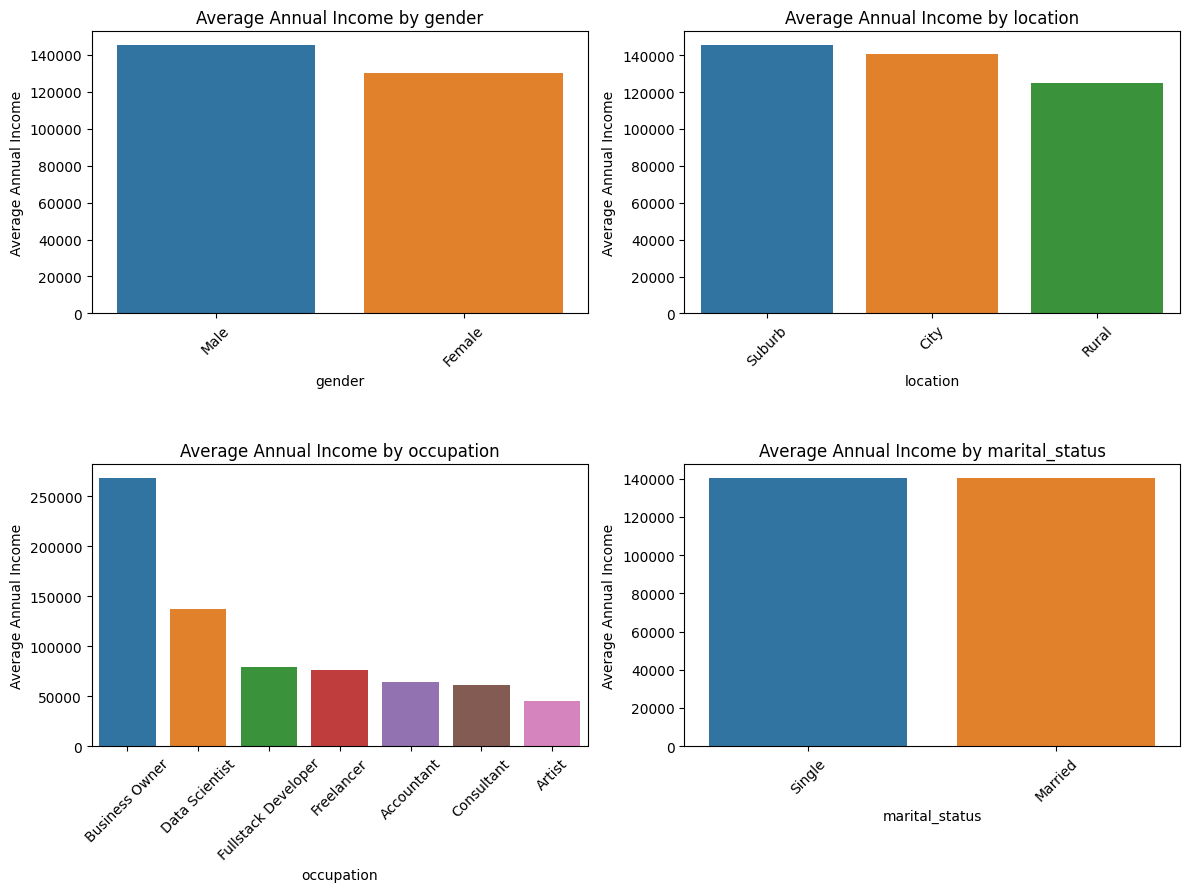

In [30]:
# List of categorical columns
cat_cols = ['gender', 'location', 'occupation', 'marital_status']

num_rows = 3
# Create subplots
fig, axes = plt.subplots(num_rows, 2, figsize=(12, 4 * num_rows))

# Flatten the axes array to make it easier to iterate
axes = axes.flatten()

# Create subplots for each categorical column
for i, cat_col in enumerate(cat_cols):
    # Calculate the average annual income for each category
    avg_income_by_category = df_cust.groupby(cat_col)['annual_income'].mean().reset_index()
    
    # Sort the data by 'annual_income' before plotting
    sorted_data = avg_income_by_category.sort_values(by='annual_income', ascending=False)
    
    sns.barplot(x=cat_col, y='annual_income', data=sorted_data, ci=None, ax=axes[i], palette='tab10')
    axes[i].set_title(f'Average Annual Income by {cat_col}')
    axes[i].set_xlabel(cat_col)
    axes[i].set_ylabel('Average Annual Income')

    # Rotate x-axis labels for better readability
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

# Hide any unused subplots
for i in range(len(cat_cols), len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

# Treat Outliers in Age Column

In our customers’ dataframe, the age column has some outliers. Detect and treat them using an approach that you feel is the best, Your business manager has told you that age is valid only if it is between 15 and 80 years.



In [31]:
df_cust.describe()

,cust_id,age,annual_income
count,1000.000000,1000.000000,1000.000000
mean,500.500000,36.405000,140483.548500
std,288.819436,15.666155,110463.002934
min,1.000000,1.000000,5175.000000
25%,250.750000,26.000000,49620.500000
50%,500.500000,32.000000,115328.000000
75%,750.250000,46.000000,195514.250000
max,1000.000000,135.000000,449346.000000


In [32]:
df_cust.head(3)

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
0,1,Dhruv Bansal,Female,2,City,Business Owner,358211.0,Married
1,2,Kabir Thakur,Female,47,City,Consultant,65172.0,Single
2,3,Kriti Mangal,Male,21,City,Freelancer,22378.0,Married


In [33]:
# Boolean mask for invalid ages
outliers = df_cust[(df_cust.age< 15) | (df_cust.age> 80)]

outliers

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
0,1,Dhruv Bansal,Female,2,City,Business Owner,358211.0,Married
41,42,Manya Thakur,Male,110,City,Artist,7621.0,Married
165,166,Swara Mehtani,Female,1,City,Freelancer,39721.0,Single
174,175,Sneha Jaiswal,Male,110,City,Freelancer,23723.0,Married
222,223,Aaryan Bajaj,Male,110,Suburb,Freelancer,210987.0,Married
277,278,Amaira Dewan,Male,110,City,Consultant,96522.0,Single
295,296,Veer Anand,Male,1,Rural,Accountant,55254.0,Married
325,326,Yash Chatterjee,Male,110,City,Accountant,61021.0,Single
610,611,Advait Mangal,Male,135,Rural,Business Owner,444776.0,Married
692,693,Aarohi Dubey,Male,1,City,Business Owner,83045.0,Married


In [34]:
df_cust.age.median()

np.float64(32.0)

In [35]:
median_age_per_occupation = df_cust.groupby("occupation")["age"].median()
median_age_per_occupation

occupation
Accountant             31.5
Artist                 26.0
Business Owner         51.0
Consultant             46.0
Data Scientist         32.0
Freelancer             24.0
Fullstack Developer    27.5
Name: age, dtype: float64

In [36]:
for index, row in outliers.iterrows():
    df_cust.at[index, 'age'] = median_age_per_occupation[row['occupation']]

In [37]:
df_cust[(df_cust.age< 15) | (df_cust.age> 80)]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status


In [38]:
df_cust.describe()

,cust_id,age,annual_income
count,1000.000000,1000.000000,1000.000000
mean,500.500000,35.541500,140483.548500
std,288.819436,12.276634,110463.002934
min,1.000000,18.000000,5175.000000
25%,250.750000,26.000000,49620.500000
50%,500.500000,32.000000,115328.000000
75%,750.250000,44.250000,195514.250000
max,1000.000000,64.000000,449346.000000


# Data visualization: Age, Gender, Location

In [39]:
df_cust.head()

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
0,1,Dhruv Bansal,Female,51.0,City,Business Owner,358211.0,Married
1,2,Kabir Thakur,Female,47.0,City,Consultant,65172.0,Single
2,3,Kriti Mangal,Male,21.0,City,Freelancer,22378.0,Married
3,4,Sara Dwivedi,Male,24.0,Rural,Freelancer,33563.0,Married
4,5,Aarohi Negi,Male,48.0,City,Consultant,39406.0,Married


In [40]:
# Define the bin edges and labels
bin_edges = [17, 25, 48, 65]  # Adjust as needed
bin_labels = ['18-25', '26-48', '49-65']

# Use the cut function to bin and label the age column
df_cust['age_group']= pd.cut(df_cust['age'], bins=bin_edges, labels=bin_labels)
df_cust.head()

,cust_id,name,gender,age,location,occupation,annual_income,marital_status,age_group
0,1,Dhruv Bansal,Female,51.0,City,Business Owner,358211.0,Married,49-65
1,2,Kabir Thakur,Female,47.0,City,Consultant,65172.0,Single,26-48
2,3,Kriti Mangal,Male,21.0,City,Freelancer,22378.0,Married,18-25
3,4,Sara Dwivedi,Male,24.0,Rural,Freelancer,33563.0,Married,18-25
4,5,Aarohi Negi,Male,48.0,City,Consultant,39406.0,Married,26-48


In [41]:
age_group_counts = df_cust.age_group.value_counts(normalize=True)*100
age_group_counts                                            

age_group
26-48    56.7
18-25    24.6
49-65    18.7
Name: proportion, dtype: float64

In [42]:
age_group_counts.index

CategoricalIndex(['26-48', '18-25', '49-65'], categories=['18-25', '26-48', '49-65'], ordered=True, dtype='category', name='age_group')

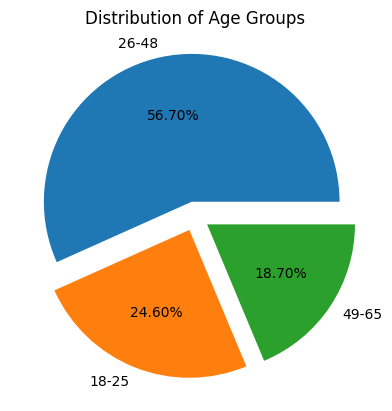

In [43]:
plt.pie(age_group_counts, labels=age_group_counts.index, autopct= '%1.2f%%', explode=(0.1,0.1,0.1))
plt.title("Distribution of Age Groups")
plt.show() 

In [44]:
df_cust.location.value_counts()

location
City      683
Suburb    232
Rural      85
Name: count, dtype: int64

In [45]:
df_cust.gender.value_counts()

gender
Male      674
Female    326
Name: count, dtype: int64

In [46]:
customer_location_gender = df_cust.groupby(['location','gender']).size().unstack()
customer_location_gender 

gender,Female,Male
location,,
City,226,457
Rural,26,59
Suburb,74,158


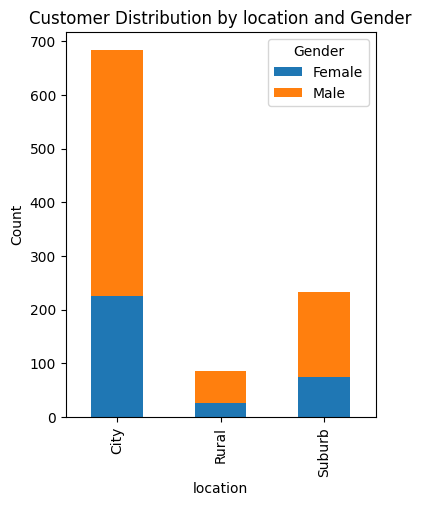

In [47]:
customer_location_gender.plot(kind="bar", stacked = True, figsize=(4,5))

plt.title('Customer Distribution by location and Gender')

plt.legend(title="Gender")

plt.xlabel('location')
plt.ylabel('Count')
plt.show()

# Explore Credit Score Table 

In [48]:
df_cs = pd.read_csv("dataset/credit_profiles.csv")
df_cs

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
0,1,749,0.585171,19571.0,0.0,40000.0
1,2,587,0.107928,161644.0,2.0,1250.0
2,3,544,0.854807,513.0,4.0,1000.0
3,4,504,0.336938,224.0,2.0,1000.0
4,5,708,0.586151,18090.0,2.0,40000.0
...,...,...,...,...,...,...
999,996,564,0.702963,688.0,2.0,1250.0
1000,997,774,0.465462,17139.0,0.0,60000.0
1001,998,529,0.585856,386.0,3.0,1000.0
1002,999,725,0.249670,6973.0,2.0,40000.0


In [49]:
df_cs.shape

(1004, 6)

In [50]:
 df_cust.shape

(1000, 9)

In [51]:
df_cs['cust_id'].nunique()

1000

In [52]:
df_cs[df_cs['cust_id'].duplicated(keep = False)]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
516,517,308,NaN,NaN,NaN,NaN
517,517,308,0.113860,33.0,3.0,500.0
569,569,344,NaN,NaN,NaN,NaN
570,569,344,0.112599,37.0,0.0,500.0
607,606,734,NaN,NaN,NaN,NaN
608,606,734,0.193418,4392.0,1.0,40000.0
664,662,442,NaN,NaN,NaN,NaN
665,662,442,0.856039,266.0,2.0,500.0


In [53]:
df_cs_clean_1 = df_cs.drop_duplicates(subset="cust_id", keep ="last")
df_cs_clean_1.shape

(1000, 6)

In [54]:
df_cs_clean_1[df_cs_clean_1['cust_id'].duplicated(keep = False)]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit


In [55]:
df_cs_clean_1.isnull().sum()

cust_id                            0
credit_score                       0
credit_utilisation                 0
outstanding_debt                   0
credit_inquiries_last_6_months     0
credit_limit                      65
dtype: int64

In [56]:
df_cs_clean_1[df_cs_clean_1.credit_limit.isnull()] 

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
10,11,679,0.557450,9187.0,2.0,NaN
35,36,790,0.112535,4261.0,1.0,NaN
37,38,514,0.296971,238.0,2.0,NaN
45,46,761,0.596041,24234.0,2.0,NaN
64,65,734,0.473715,13631.0,0.0,NaN
...,...,...,...,...,...,...
912,909,479,0.487555,320.0,3.0,NaN
931,928,311,0.832244,316.0,2.0,NaN
948,945,526,0.272734,227.0,1.0,NaN
954,951,513,0.175914,131.0,3.0,NaN


In [57]:
df_cs_clean_1.credit_limit.value_counts()

credit_limit
500.0      229
60000.0    186
40000.0    137
1500.0     100
1000.0      90
750.0       76
1250.0      75
20000.0     42
Name: count, dtype: int64

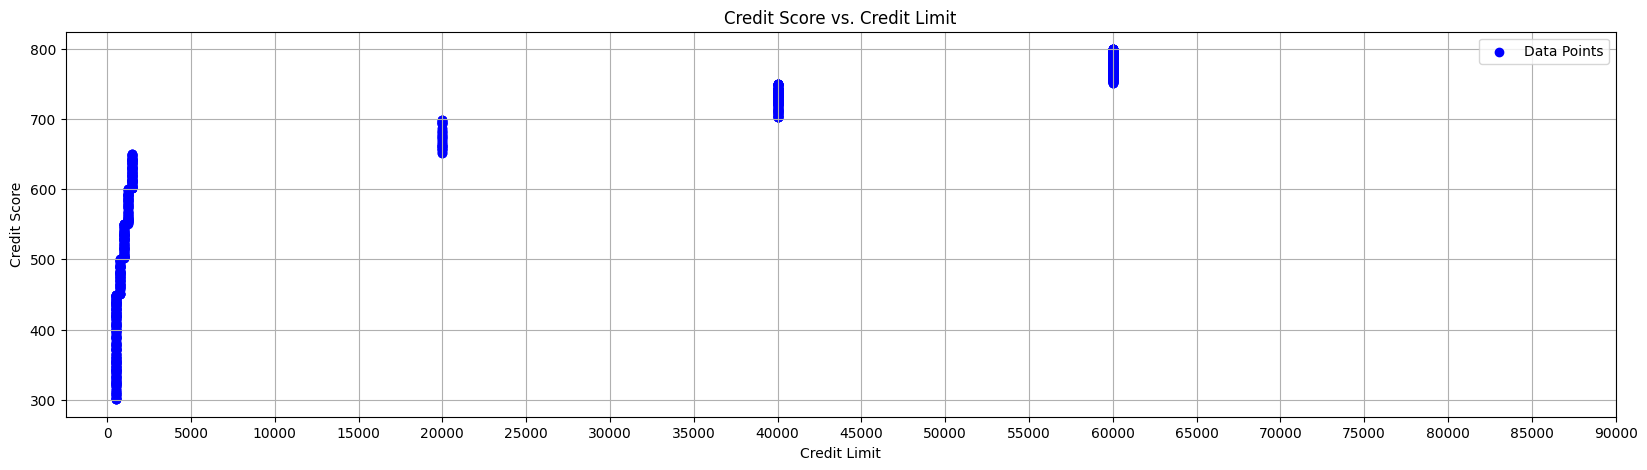

In [58]:
plt.figure(figsize=(20, 5))
plt.scatter(df_cs_clean_1['credit_limit'], df_cs_clean_1['credit_score'], c='blue', marker='o', label='Data Points')

# Customize the plot
plt.title('Credit Score vs. Credit Limit')
plt.xlabel('Credit Limit')
plt.ylabel('Credit Score')

# Adjust the y-axis bin interval to 1000
plt.xticks(range(0, 90001, 5000))
plt.grid(True)

# Show the plot
plt.legend()
plt.show()

In [59]:
bin_ranges = [300, 450, 500, 550, 600,700,750,800] 

In [60]:
# Define bin ranges
bin_ranges = [300, 450, 500, 550, 600, 650, 700, 750, 800]

# Create labels for the bins
bin_labels = [f'{start}-{end-1}' for start, end in zip(bin_ranges, bin_ranges[1:])]

# Use pd.cut to assign data to bins
df_cs_clean_1['credit_score_range'] = pd.cut(df_cs_clean_1['credit_score'], bins=bin_ranges, labels=bin_labels, include_lowest=True, right=False)

In [61]:
df_cs_clean_1.head()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range
0,1,749,0.585171,19571.0,0.0,40000.0,700-749
1,2,587,0.107928,161644.0,2.0,1250.0,550-599
2,3,544,0.854807,513.0,4.0,1000.0,500-549
3,4,504,0.336938,224.0,2.0,1000.0,500-549
4,5,708,0.586151,18090.0,2.0,40000.0,700-749


In [62]:
df_cs_clean_1[df_cs_clean_1.credit_score_range=="700-749"]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range
0,1,749,0.585171,19571.0,0.0,40000.0,700-749
4,5,708,0.586151,18090.0,2.0,40000.0,700-749
6,7,747,0.523965,15544.0,4.0,40000.0,700-749
16,17,702,0.894423,18444.0,0.0,40000.0,700-749
27,28,729,0.149748,3453.0,2.0,40000.0,700-749
...,...,...,...,...,...,...,...
969,966,720,0.203742,6159.0,4.0,40000.0,700-749
970,967,739,0.845474,23929.0,4.0,40000.0,700-749
991,988,739,0.435891,9283.0,4.0,40000.0,700-749
994,991,709,0.718484,15473.0,4.0,40000.0,700-749


In [63]:
mode_df = df_cs_clean_1.groupby("credit_score_range")["credit_limit"].agg(lambda x: x.mode().iloc[0]).reset_index()
mode_df

,credit_score_range,credit_limit
0,300-449,500.0
1,450-499,750.0
2,500-549,1000.0
3,550-599,1250.0
4,600-649,1500.0
5,650-699,20000.0
6,700-749,40000.0
7,750-799,60000.0


In [64]:
df_cs_clean_2 = pd.merge(df_cs_clean_1, mode_df, on='credit_score_range', suffixes=('', '_mode'))
df_cs_clean_2.sample(3)

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode
891,892,744,0.629654,14794.0,0.0,40000.0,700-749,40000.0
663,664,553,0.388849,299.0,1.0,1250.0,550-599,1250.0
631,632,584,0.497355,375.0,3.0,1250.0,550-599,1250.0


In [65]:
df_cs_clean_2[df_cs_clean_2.credit_limit.isnull()].sample(3)

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode
83,84,733,0.525567,16663.0,1.0,NaN,700-749,40000.0
768,769,563,0.865592,898.0,3.0,NaN,550-599,1250.0
757,758,783,0.801201,28920.0,3.0,NaN,750-799,60000.0


In [66]:
df_cs_clean_2['credit_limit'] = df_cs_clean_2['credit_limit'].fillna(
    df_cs_clean_2['credit_limit_mode']
)

df_cs_clean_2.sample(6)

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode
403,404,536,0.284229,151.0,2.0,1000.0,500-549,1000.0
63,64,559,0.756232,688.0,4.0,1250.0,550-599,1250.0
271,272,703,0.446886,154568.0,1.0,40000.0,700-749,40000.0
886,887,489,0.254389,151.0,0.0,750.0,450-499,750.0
955,956,518,0.551262,452.0,0.0,1000.0,500-549,1000.0
666,667,609,0.302710,283.0,2.0,1500.0,600-649,1500.0


In [67]:
df_cs_clean_2.loc[[717]]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode
717,718,481,0.127147,68.0,0.0,750.0,450-499,750.0


In [68]:
df_cs_clean_2.describe()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_limit_mode
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,500.500000,589.182000,0.498950,9683.597000,1.955000,19733.75000,19912.500000
std,288.819436,152.284929,0.233139,25255.893671,1.414559,24717.43818,24840.914633
min,1.000000,300.000000,0.103761,33.000000,0.000000,500.00000,500.000000
25%,250.750000,460.000000,0.293917,221.000000,1.000000,750.00000,750.000000
50%,500.500000,601.500000,0.487422,550.000000,2.000000,1500.00000,1500.000000
75%,750.250000,738.000000,0.697829,11819.500000,3.000000,40000.00000,40000.000000
max,1000.000000,799.000000,0.899648,209901.000000,4.000000,60000.00000,60000.000000


<Axes: xlabel='outstanding_debt'>

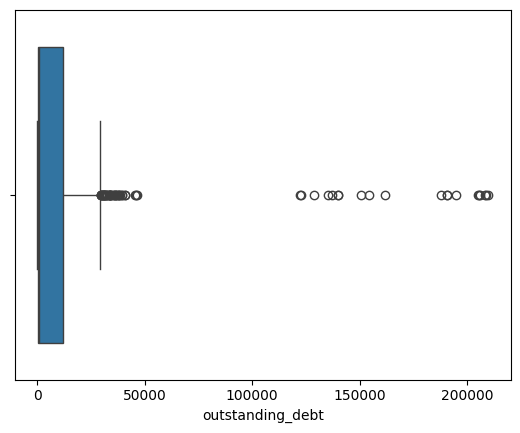

In [69]:
sns.boxplot(x =df_cs_clean_2.outstanding_debt)

In [70]:
df_cs_clean_2[df_cs_clean_2.outstanding_debt>df_cs_clean_2.credit_limit] 

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode
1,2,587,0.107928,161644.0,2.0,1250.0,550-599,1250.0
19,20,647,0.439132,205014.0,3.0,1500.0,600-649,1500.0
25,26,758,0.250811,190838.0,2.0,60000.0,750-799,60000.0
38,39,734,0.573023,122758.0,3.0,40000.0,700-749,40000.0
93,94,737,0.739948,137058.0,2.0,40000.0,700-749,40000.0
204,205,303,0.364360,187849.0,0.0,500.0,300-449,500.0
271,272,703,0.446886,154568.0,1.0,40000.0,700-749,40000.0
301,302,722,0.608076,122402.0,4.0,40000.0,700-749,40000.0
330,331,799,0.363420,208898.0,4.0,60000.0,750-799,60000.0
350,351,320,0.285081,150860.0,0.0,500.0,300-449,500.0


In [71]:
df_cs_clean_2.loc[df_cs_clean_2['outstanding_debt'] > df_cs_clean_2['credit_limit'], 'outstanding_debt']

1      161644.0
19     205014.0
25     190838.0
38     122758.0
93     137058.0
204    187849.0
271    154568.0
301    122402.0
330    208898.0
350    150860.0
446    206191.0
544    135112.0
636    140063.0
646    128818.0
698    190717.0
723    140008.0
725    205404.0
730    209901.0
766    195004.0
862    208406.0
Name: outstanding_debt, dtype: float64

In [72]:
df_cs_clean_2.loc[df_cs_clean_2['outstanding_debt'] > df_cs_clean_2['credit_limit'], 'outstanding_debt'] = df_cs_clean_2['credit_limit'] 

In [73]:
df_cs_clean_2.loc[[55,93]]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode
55,56,429,0.198374,74.0,3.0,500.0,300-449,500.0
93,94,737,0.739948,40000.0,2.0,40000.0,700-749,40000.0


In [74]:
df_merged = df_cust.merge(df_cs_clean_2, on="cust_id", how="inner")
df_merged.head()

,cust_id,name,gender,age,location,occupation,annual_income,marital_status,age_group,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode
0,1,Dhruv Bansal,Female,51.0,City,Business Owner,358211.0,Married,49-65,749,0.585171,19571.0,0.0,40000.0,700-749,40000.0
1,2,Kabir Thakur,Female,47.0,City,Consultant,65172.0,Single,26-48,587,0.107928,1250.0,2.0,1250.0,550-599,1250.0
2,3,Kriti Mangal,Male,21.0,City,Freelancer,22378.0,Married,18-25,544,0.854807,513.0,4.0,1000.0,500-549,1000.0
3,4,Sara Dwivedi,Male,24.0,Rural,Freelancer,33563.0,Married,18-25,504,0.336938,224.0,2.0,1000.0,500-549,1000.0
4,5,Aarohi Negi,Male,48.0,City,Consultant,39406.0,Married,26-48,708,0.586151,18090.0,2.0,40000.0,700-749,40000.0


In [75]:
numerical_cols = ['credit_score', 'credit_utilisation', 'outstanding_debt', 'credit_limit', 'annual_income','age']

correlation_matrix = df_merged[numerical_cols].corr()
correlation_matrix

,credit_score,credit_utilisation,outstanding_debt,credit_limit,annual_income,age
credit_score,1.000000,-0.070445,0.680654,0.847952,0.575751,0.444917
credit_utilisation,-0.070445,1.000000,0.192838,-0.080493,-0.086368,-0.027713
outstanding_debt,0.680654,0.192838,1.000000,0.810581,0.555661,0.444301
credit_limit,0.847952,-0.080493,0.810581,1.000000,0.684775,0.510993
annual_income,0.575751,-0.086368,0.555661,0.684775,1.000000,0.619037
age,0.444917,-0.027713,0.444301,0.510993,0.619037,1.000000


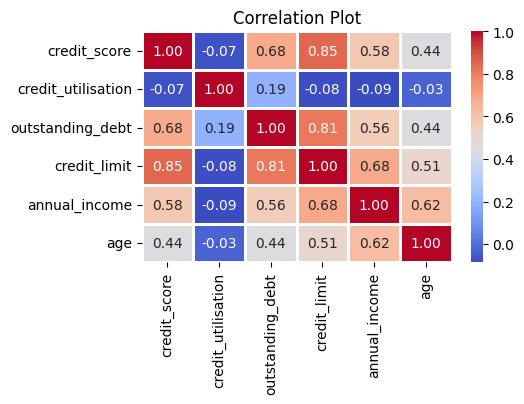

In [76]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(5, 3))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.8)
plt.title('Correlation Plot')
plt.show()

# handling Null values in Transaction Table

In [77]:
df_tran = pd.read_csv("dataset/transactions.csv")
df_tran

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
0,1,705,2023-01-01,63,Flipkart,Electronics,Phonepe
1,2,385,2023-01-01,99,Alibaba,Fashion & Apparel,Credit Card
2,3,924,2023-01-01,471,Shopify,Sports,Phonepe
3,4,797,2023-01-01,33,Shopify,Fashion & Apparel,Gpay
4,5,482,2023-01-01,68,Amazon,Fashion & Apparel,Net Banking
...,...,...,...,...,...,...,...
499995,499996,791,2023-09-05,43,Amazon,Books,Phonepe
499996,499997,569,2023-09-05,53022,Meesho,Fashion & Apparel,Net Banking
499997,499998,57,2023-09-05,224,NaN,Garden & Outdoor,Phonepe
499998,499999,629,2023-09-05,538,Flipkart,Home Decor,Gpay


In [78]:
df_tran[df_tran.isnull().any(axis=1)]

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
355,356,58,2023-01-01,237,NaN,Electronics,Net Banking
418,419,383,2023-01-01,338,NaN,Electronics,Credit Card
607,608,421,2023-01-01,700,NaN,Electronics,Phonepe
844,845,945,2023-01-01,493,NaN,Sports,Credit Card
912,913,384,2023-01-01,85,NaN,Fashion & Apparel,Phonepe
...,...,...,...,...,...,...,...
499579,499580,924,2023-09-05,31,NaN,Fashion & Apparel,Gpay
499646,499647,944,2023-09-05,58445,NaN,Fashion & Apparel,Phonepe
499725,499726,620,2023-09-05,15,NaN,Sports,Net Banking
499833,499834,616,2023-09-05,97,NaN,Fashion & Apparel,Credit Card


In [79]:
df_tran.platform.unique()

array(['Flipkart', 'Alibaba', 'Shopify', 'Amazon', 'Ebay', 'Meesho',
       'Cred', nan], dtype=object)

In [80]:
df_tran.platform.mode()

0    Amazon
Name: platform, dtype: object

<Axes: xlabel='count', ylabel='product_category'>

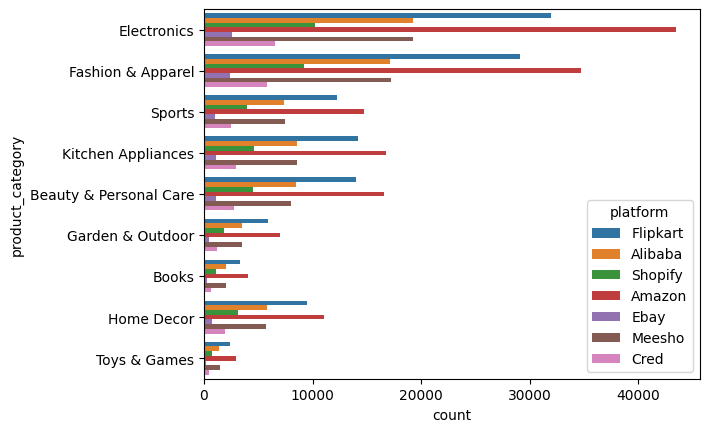

In [81]:
sns.countplot(y="product_category", hue="platform", data =df_tran )

In [82]:
df_tran.platform.mode()[0]

'Amazon'

In [83]:
df_tran['platform'].fillna(df_trans.platform.mode()[0], inplace=True)

In [84]:
df_tran.isnull().sum()

tran_id             0
cust_id             0
tran_date           0
tran_amount         0
platform            0
product_category    0
payment_type        0
dtype: int64

# Data Cleaning Step 2: Treat Outliers: tran_amount

In [85]:
df_tran.describe()

,tran_id,cust_id,tran_amount
count,500000.000000,500000.000000,500000.00000
mean,250000.500000,501.400428,3225.20733
std,144337.711635,288.641924,13098.74276
min,1.000000,1.000000,0.00000
25%,125000.750000,252.000000,64.00000
50%,250000.500000,502.000000,141.00000
75%,375000.250000,752.000000,397.00000
max,500000.000000,1000.000000,69999.00000


In [86]:
df_trans_zero = df_tran[df_tran.tran_amount==0]
df_trans_zero.shape

(4734, 7)

In [87]:
df_trans_zero.head()

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
120,121,440,2023-01-01,0,Amazon,Electronics,Credit Card
141,142,839,2023-01-01,0,Amazon,Electronics,Credit Card
517,518,147,2023-01-01,0,Amazon,Electronics,Credit Card
533,534,891,2023-01-01,0,Amazon,Electronics,Credit Card
586,587,108,2023-01-01,0,Amazon,Electronics,Credit Card


In [88]:
df_trans_zero[["platform", "product_category", "payment_type"]].value_counts()

platform  product_category  payment_type
Amazon    Electronics       Credit Card     4734
Name: count, dtype: int64

In [89]:
df_trans_1 = df_tran[(df_tran.platform=='Amazon')&(df_tran.product_category=="Electronics")&(df_tran.payment_type=="Credit Card")]
df_trans_1.head()

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
109,110,887,2023-01-01,635,Amazon,Electronics,Credit Card
120,121,440,2023-01-01,0,Amazon,Electronics,Credit Card
141,142,839,2023-01-01,0,Amazon,Electronics,Credit Card
173,174,676,2023-01-01,60439,Amazon,Electronics,Credit Card
190,191,763,2023-01-01,697,Amazon,Electronics,Credit Card


In [90]:
median_to_replace = df_trans_1[df_trans_1.tran_amount>0].tran_amount.median()
median_to_replace

np.float64(554.0)

In [91]:
df_tran['tran_amount'].replace(0,median_to_replace, inplace=True)


In [92]:
df_tran.describe()

,tran_id,cust_id,tran_amount
count,500000.000000,500000.000000,500000.000000
mean,250000.500000,501.400428,3230.452602
std,144337.711635,288.641924,13097.561071
min,1.000000,1.000000,2.000000
25%,125000.750000,252.000000,66.000000
50%,250000.500000,502.000000,146.000000
75%,375000.250000,752.000000,413.000000
max,500000.000000,1000.000000,69999.000000


In [93]:
Q1, Q3 = df_tran["tran_amount"].quantile([0.25, 0.75])

IQR = Q3-Q1

lower = Q1 - 2 *IQR
upper = Q3 + 2*IQR

lower,upper

(-628.0, 1107.0)

In [94]:
df_tran_outliers = df_tran[df_tran.tran_amount>=upper]
df_tran_outliers.shape

(25000, 7)

In [95]:
df_trans_normal = df_tran[df_tran.tran_amount<upper]
df_trans_normal.head()

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
0,1,705,2023-01-01,63,Flipkart,Electronics,Phonepe
1,2,385,2023-01-01,99,Alibaba,Fashion & Apparel,Credit Card
2,3,924,2023-01-01,471,Shopify,Sports,Phonepe
3,4,797,2023-01-01,33,Shopify,Fashion & Apparel,Gpay
4,5,482,2023-01-01,68,Amazon,Fashion & Apparel,Net Banking


In [96]:
tran_mean_per_category = df_trans_normal.groupby("product_category")["tran_amount"].mean()
tran_mean_per_category

product_category
Beauty & Personal Care     92.167205
Books                      29.553515
Electronics               510.172685
Fashion & Apparel          64.553463
Garden & Outdoor          125.630277
Home Decor                302.487561
Kitchen Appliances        176.773288
Sports                    269.181631
Toys & Games               50.333298
Name: tran_amount, dtype: float64

In [97]:
df_tran.loc[df_tran_outliers.index]

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
26,27,380,2023-01-01,61963,Shopify,Beauty & Personal Care,Credit Card
49,50,287,2023-01-01,57869,Amazon,Toys & Games,Gpay
94,95,770,2023-01-01,52881,Ebay,Kitchen Appliances,Credit Card
104,105,549,2023-01-01,58574,Flipkart,Fashion & Apparel,Gpay
113,114,790,2023-01-01,51669,Shopify,Kitchen Appliances,Credit Card
...,...,...,...,...,...,...,...
499742,499743,868,2023-09-05,55131,Meesho,Fashion & Apparel,Gpay
499888,499889,614,2023-09-05,59679,Meesho,Fashion & Apparel,Net Banking
499900,499901,811,2023-09-05,60184,Flipkart,Sports,Debit Card
499966,499967,662,2023-09-05,54678,Meesho,Sports,Gpay


In [98]:
df_tran.loc[df_tran_outliers.index, 'tran_amount'] = df_tran_outliers['product_category'].map(tran_mean_per_category)

In [99]:
df_tran.loc[df_tran_outliers.index]

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
26,27,380,2023-01-01,92.167205,Shopify,Beauty & Personal Care,Credit Card
49,50,287,2023-01-01,50.333298,Amazon,Toys & Games,Gpay
94,95,770,2023-01-01,176.773288,Ebay,Kitchen Appliances,Credit Card
104,105,549,2023-01-01,64.553463,Flipkart,Fashion & Apparel,Gpay
113,114,790,2023-01-01,176.773288,Shopify,Kitchen Appliances,Credit Card
...,...,...,...,...,...,...,...
499742,499743,868,2023-09-05,64.553463,Meesho,Fashion & Apparel,Gpay
499888,499889,614,2023-09-05,64.553463,Meesho,Fashion & Apparel,Net Banking
499900,499901,811,2023-09-05,269.181631,Flipkart,Sports,Debit Card
499966,499967,662,2023-09-05,269.181631,Meesho,Sports,Gpay


<Axes: xlabel='tran_amount', ylabel='Count'>

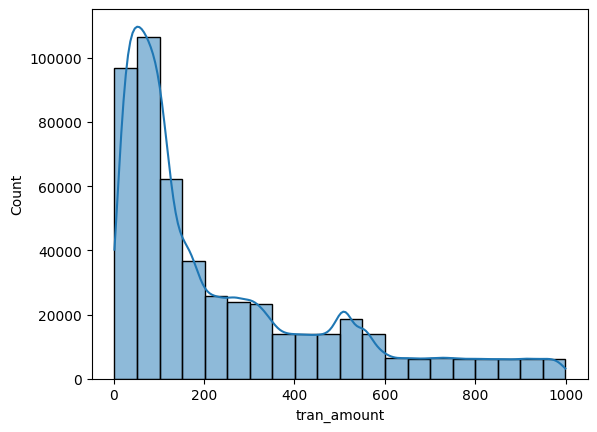

In [100]:
sns.histplot(x='tran_amount', data=df_tran, bins=20, kde=True)

# Data Visualization:Transactions Table

In [101]:
df_tran.head()

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
0,1,705,2023-01-01,63.0,Flipkart,Electronics,Phonepe
1,2,385,2023-01-01,99.0,Alibaba,Fashion & Apparel,Credit Card
2,3,924,2023-01-01,471.0,Shopify,Sports,Phonepe
3,4,797,2023-01-01,33.0,Shopify,Fashion & Apparel,Gpay
4,5,482,2023-01-01,68.0,Amazon,Fashion & Apparel,Net Banking


<Axes: xlabel='payment_type', ylabel='percent'>

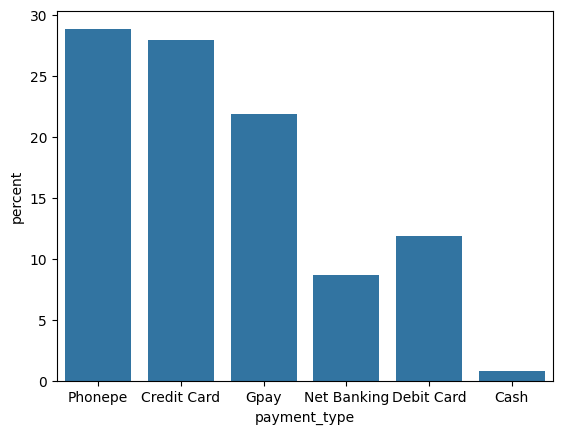

In [102]:
sns.countplot(x=df_tran.payment_type, stat="percent")

In [103]:
df_cust.head()

,cust_id,name,gender,age,location,occupation,annual_income,marital_status,age_group
0,1,Dhruv Bansal,Female,51.0,City,Business Owner,358211.0,Married,49-65
1,2,Kabir Thakur,Female,47.0,City,Consultant,65172.0,Single,26-48
2,3,Kriti Mangal,Male,21.0,City,Freelancer,22378.0,Married,18-25
3,4,Sara Dwivedi,Male,24.0,Rural,Freelancer,33563.0,Married,18-25
4,5,Aarohi Negi,Male,48.0,City,Consultant,39406.0,Married,26-48


In [104]:
df_merged_2 = pd.merge(df_cust, df_tran, on="cust_id", how="inner")
df_merged_2.head()

,cust_id,name,gender,age,location,occupation,annual_income,marital_status,age_group,tran_id,tran_date,tran_amount,platform,product_category,payment_type
0,1,Dhruv Bansal,Female,51.0,City,Business Owner,358211.0,Married,49-65,1283,2023-01-01,30.0,Shopify,Fashion & Apparel,Net Banking
1,1,Dhruv Bansal,Female,51.0,City,Business Owner,358211.0,Married,49-65,1382,2023-01-01,96.0,Amazon,Sports,Debit Card
2,1,Dhruv Bansal,Female,51.0,City,Business Owner,358211.0,Married,49-65,1521,2023-01-01,86.0,Meesho,Garden & Outdoor,Gpay
3,1,Dhruv Bansal,Female,51.0,City,Business Owner,358211.0,Married,49-65,1576,2023-01-01,149.0,Amazon,Beauty & Personal Care,Phonepe
4,1,Dhruv Bansal,Female,51.0,City,Business Owner,358211.0,Married,49-65,1757,2023-01-01,37.0,Flipkart,Fashion & Apparel,Credit Card


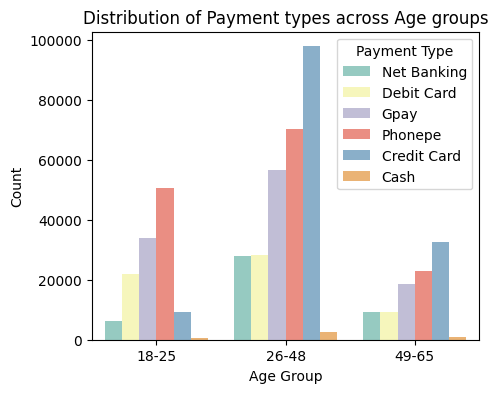

In [105]:
plt.figure(figsize=(5, 4))
sns.countplot(x='age_group', hue='payment_type', data=df_merged_2, palette='Set3')
plt.title('Distribution of Payment types across Age groups')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Payment Type', loc='upper right')

plt.show()

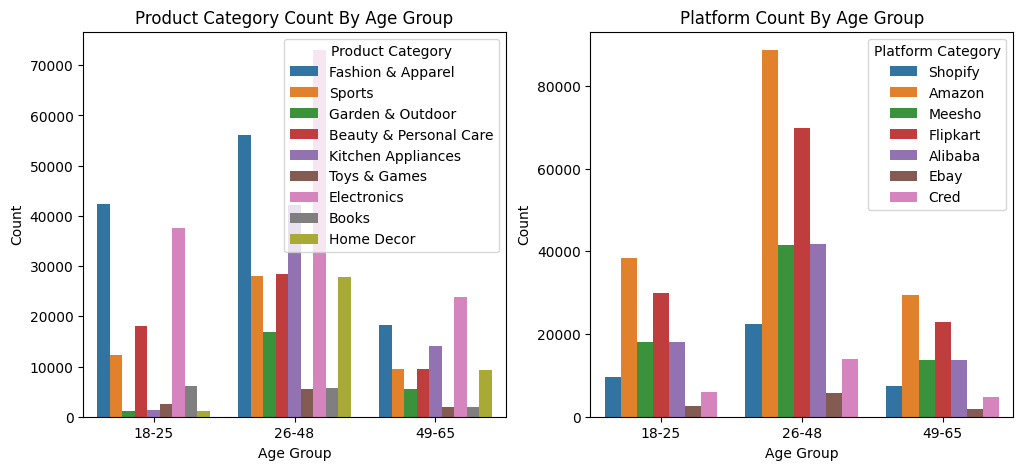

In [106]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

sns.countplot(x='age_group', hue="product_category", data=df_merged_2, ax=ax1)
ax1.set_title("Product Category Count By Age Group")
ax1.set_xlabel("Age Group")
ax1.set_ylabel("Count")
ax1.legend(title="Product Category", loc='upper right')

sns.countplot(x='age_group', hue="platform", data=df_merged_2, ax=ax2)
ax2.set_title("Platform Count By Age Group")
ax2.set_xlabel("Age Group")
ax2.set_ylabel("Count")
ax2.legend(title="Platform Category", loc='upper right')

plt.show()

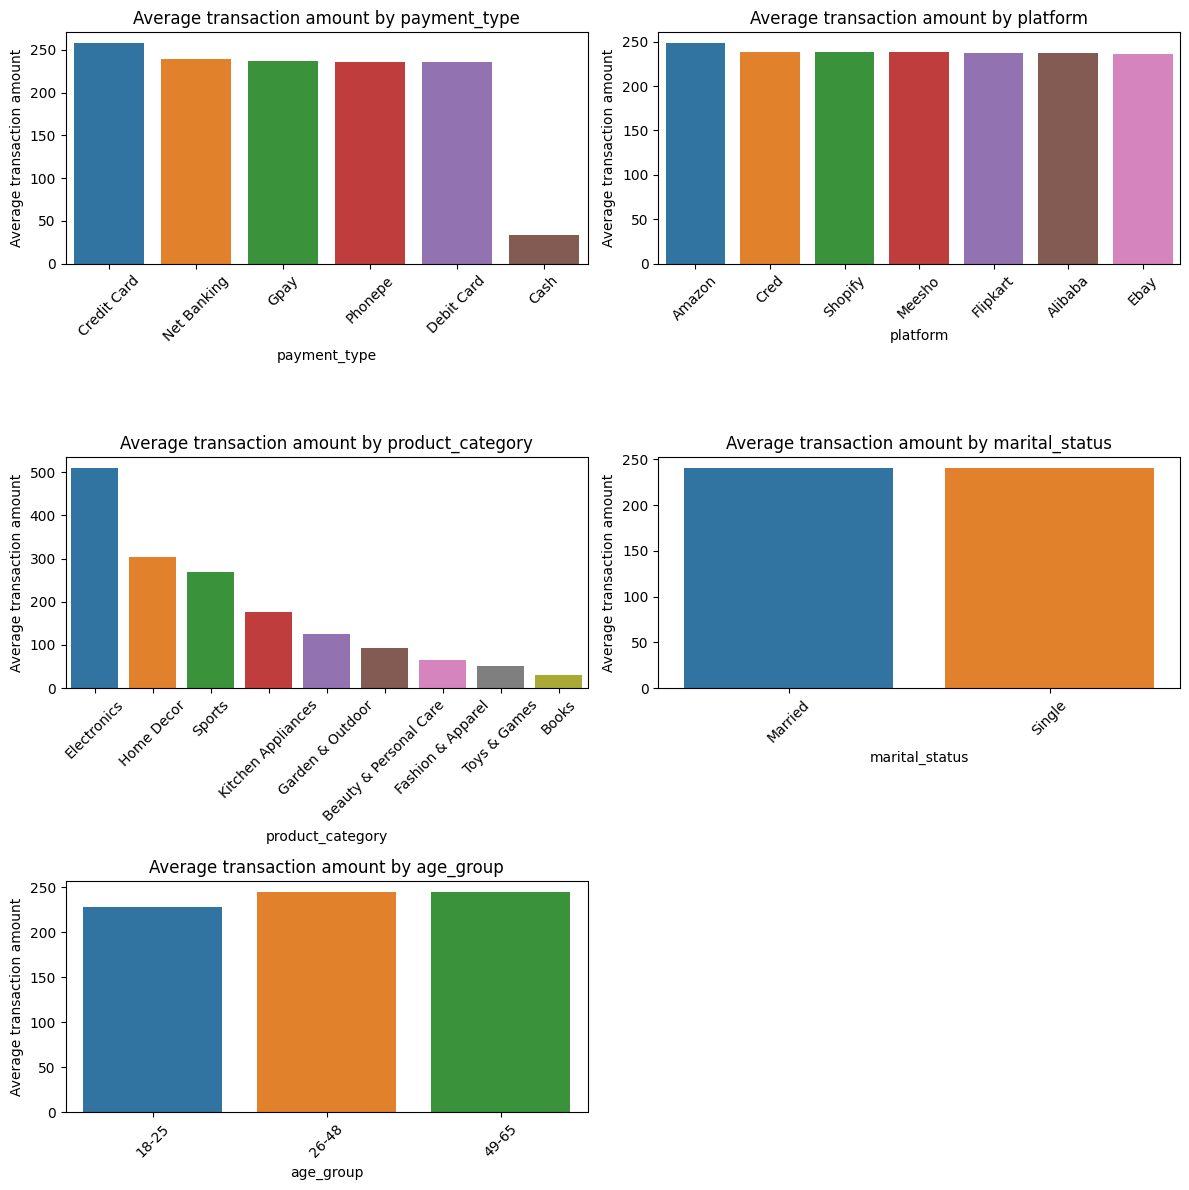

In [107]:
# List of categorical columns
cat_cols = ['payment_type', 'platform', 'product_category', 'marital_status', 'age_group']

num_rows = 3
# Create subplots
fig, axes = plt.subplots(num_rows, 2, figsize=(12, 4 * num_rows))

# Flatten the axes array to make it easier to iterate
axes = axes.flatten()

# Create subplots for each categorical column
for i, cat_col in enumerate(cat_cols):
    # Calculate the average annual income for each category
    avg_tran_amount_by_category = df_merged_2.groupby(cat_col)['tran_amount'].mean().reset_index()
    
    # Sort the data by 'annual_income' before plotting
    sorted_data = avg_tran_amount_by_category.sort_values(by='tran_amount', ascending=False)
    
    sns.barplot(x=cat_col, y='tran_amount', data=sorted_data, ci=None, ax=axes[i], palette='tab10')
    axes[i].set_title(f'Average transaction amount by {cat_col}')
    axes[i].set_xlabel(cat_col)
    axes[i].set_ylabel('Average transaction amount')

    # Rotate x-axis labels for better readability
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

# Hide any unused subplots
for i in range(len(cat_cols), len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

In [108]:
# Group the data by age group and calculate the average credit_limit and credit_score
age_group_metrics = df_merged.groupby('age_group')[['annual_income', 'credit_limit', 'credit_score']].mean().reset_index()
age_group_metrics

,age_group,annual_income,credit_limit,credit_score
0,18-25,37091.235772,1130.081301,484.451220
1,26-48,145869.623457,20560.846561,597.569665
2,49-65,260165.925134,41699.197861,701.524064


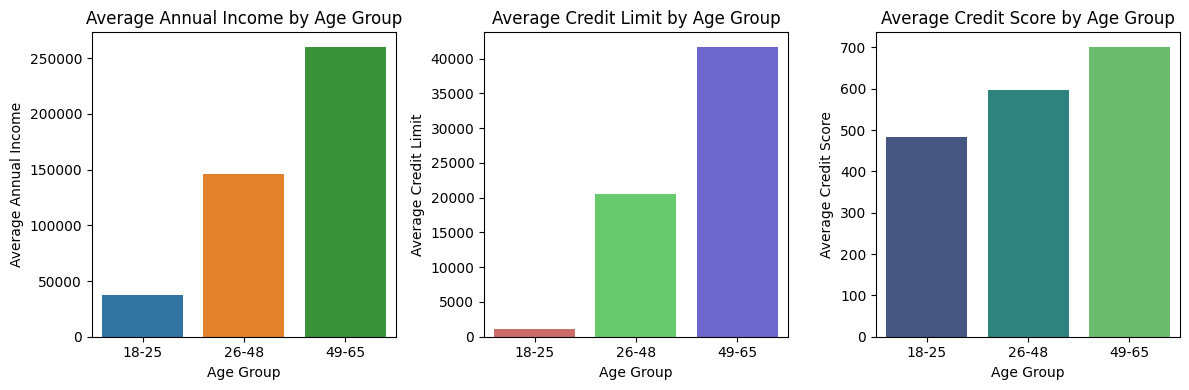

In [109]:
# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# Plot 1: Average annual income by age group
sns.barplot(x='age_group', y='annual_income', data=age_group_metrics, palette='tab10', ax=ax1)
ax1.set_title('Average Annual Income by Age Group')
ax1.set_xlabel('Age Group')
ax1.set_ylabel('Average Annual Income')
ax1.tick_params(axis='x', rotation=0)

# Plot 2: Average Max Credit Limit by Age Group
sns.barplot(x='age_group', y='credit_limit', data=age_group_metrics, palette='hls', ax=ax2)
ax2.set_title('Average Credit Limit by Age Group')
ax2.set_xlabel('Age Group')
ax2.set_ylabel('Average Credit Limit')
ax2.tick_params(axis='x', rotation=0)

# Plot 3: Average Credit Score by Age Group
sns.barplot(x='age_group', y='credit_score', data=age_group_metrics, palette='viridis', ax=ax3)
ax3.set_title('Average Credit Score by Age Group')
ax3.set_xlabel('Age Group')
ax3.set_ylabel('Average Credit Score')
ax3.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# Bank Credit Card Project with AB testing 

### Business Analysis and launch of AB testing: Targeting Untapped Market

### Insights specific to customers with age group of 18 - 25
1. People with age group of 18 -25 accounts to ~25% of customer base in the data
2. Avg annual income of this age group is less than 50k
3. They don't have much credit history which is getting reflected in their credit score and max credit limit 
4. Usage of credit cards as payment type is relatively low compared to other groups
5. Avg transaction amount made with credit cards is also low compared to other groups
5. Top 3 most used shopping products categories  : Electronics, Fashion & Apparel, Beauty & Personal care

In [110]:
ls analysis.png

analysis.png


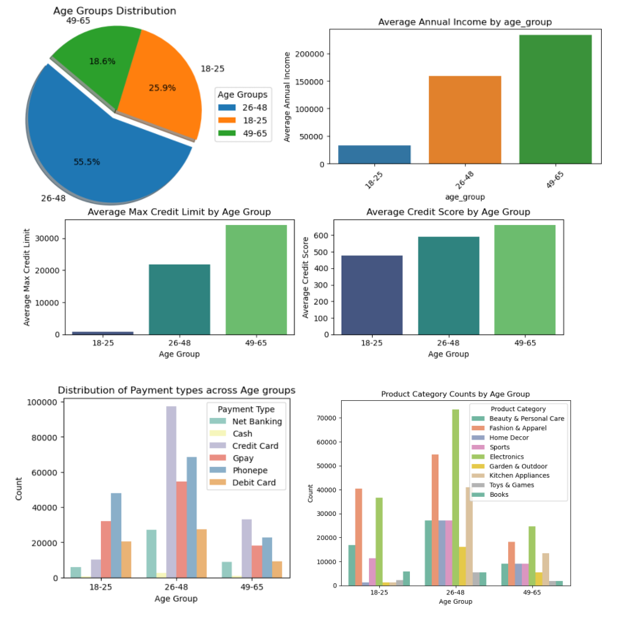

In [111]:
from IPython.display import Image, display
display(Image(filename="analysis.png"))

## (1) Pre-Campaign

We want to do a trial run for our new credit card. For this we need to figure out (1) How many customers do we need for our A/B testing. We will form a control and test group. For both of these groups we can figure out number of customers we need based on the statistical power and effect size that we agree upon after discussing with business. We will use 

In [112]:
alpha = 0.05 # 5% significance
power = 0.8
effect_size = 0.2


sms.tt_ind_solve_power(
    effect_size=0.2, 
    alpha=alpha, 
    power=power, 
    ratio=1, 
    alternative='two-sided'
)

393.4056930002514

In [113]:
# Calculate the required sample size for different effect sizes
effect_sizes = [0.1, 0.2, 0.3, 0.4, 0.5,1]  #  standard deviations greater than control group 

for effect_size in effect_sizes:
    sample_size = sms.tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, ratio=1, alternative='two-sided')
    print(f"Effect Size: {effect_size}, Required Sample Size: {int(sample_size)} customers")

Effect Size: 0.1, Required Sample Size: 1570 customers
Effect Size: 0.2, Required Sample Size: 393 customers
Effect Size: 0.3, Required Sample Size: 175 customers
Effect Size: 0.4, Required Sample Size: 99 customers
Effect Size: 0.5, Required Sample Size: 63 customers
Effect Size: 1, Required Sample Size: 16 customers


Based on business requirements, the test should be capable of detecting a minimum 0.4 standard deviation difference between the control and test groups. For the effect size 0.4, we need 100 customers and when we discussed with business, 100 customers is ok in terms of their budgeting constraints for this trail run

#### Forming control and test groups

1.We have identified approximately 246 customers within the age group of 18 to 25. From this pool, we will select 100 customers for the initial campaign launch.

2.The campaign is launched for 100 customers, as determined by the effective size calculation and by considering budgeting costs, and will run campaign for a duration of 2 months

3.Got a conversion rate of ~40% ( implies 40 out of 100 customers in test group started using credit card)

4.To maintain a similar sample size, a control group consisting of 40 customers will be created. Importantly, this control group will be completely exclusive of initial 100 customers used as test group.

5.So now we have 40 customers in each of control and test groups

##### At the end of the 2-month campaign period (from 09-10-23 to 11-10-23), we obtained daily data showing the average transaction amounts made by the entire group of 40 customers in both the control and test groups using existing and newly launched credit cards respectively

##### The key performance indicator (KPI) for this AB test aims to enhance average transaction amounts facilitated by the new card

## (2) Post-Campaign

## Two Sample Z Test for Our Hypothesis Testing

In [114]:
# Loading campaign results data
df = pd.read_csv('avg_transactions_after_campaignp_phase2.csv')
df.head(4)

,campaign_date,control_group_avg_tran,test_group_avg_tran
0,2023-09-10,259.83,277.32
1,2023-09-11,191.27,248.68
2,2023-09-12,212.41,286.61
3,2023-09-13,214.92,214.85


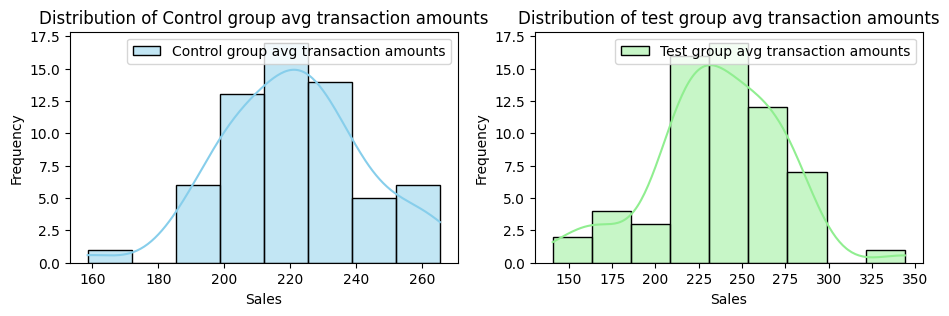

In [115]:
# Let's look at distributions of avg transactions amounts in both groups
# Create a 1x2 grid of subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 3))

# Plot the distribution of Campaign A Sales
sns.histplot(df['control_group_avg_tran'], kde=True, color='skyblue', label='Control group avg transaction amounts', ax=ax1)
ax1.set_xlabel('Sales')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Control group avg transaction amounts')
ax1.legend()

# Plot the distribution of Campaign B Sales
sns.histplot(df['test_group_avg_tran'], kde=True, color='lightgreen', label='Test group avg transaction amounts', ax=ax2)
ax2.set_xlabel('Sales')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of test group avg transaction amounts')
ax2.legend()

# Show the plots
plt.show()

In [116]:
df[df["control_group_avg_tran"]> df["test_group_avg_tran"]]

,campaign_date,control_group_avg_tran,test_group_avg_tran
3,2023-09-13,214.92,214.85
8,2023-09-18,265.13,212.60
9,2023-09-19,232.88,207.63
16,2023-09-26,222.95,213.30
22,2023-10-02,238.39,203.10
23,2023-10-03,253.95,234.26
25,2023-10-05,239.47,216.37
26,2023-10-06,200.70,166.70
27,2023-10-07,200.91,170.01
28,2023-10-08,188.30,150.27


In [117]:
control_mean = df["control_group_avg_tran"].mean().round(2)
control_std = df["control_group_avg_tran"].std().round(2)
control_mean, control_std

(np.float64(221.18), np.float64(21.36))

In [118]:
test_mean = df["test_group_avg_tran"].mean().round(2)
test_std = df["test_group_avg_tran"].std().round(2)
test_mean, test_std

(np.float64(235.98), np.float64(36.66))

In [119]:
sample_size = df.shape[0]
sample_size

62

In [120]:
a = test_std**2 / sample_size
b = test_std**2 / sample_size


z_score = (test_mean - control_mean) / np.sqrt (a + b)
z_score

np.float64(2.247760844786804)

In [121]:
# For a significance level of 5% (0.05) in a right-tailed test, the critical Z-value is approximately 1.645
critical_z_value = st.norm.ppf(1 - alpha)  # Right-tailed test at 5% significance level
critical_z_value

np.float64(1.644853626951472)

In [122]:
# Performing Z-test with above considerations
z_statistic, p_value = sm.stats.ztest( df['test_group_avg_tran'],df['control_group_avg_tran'],alternative = 'larger')
z_statistic, p_value

(np.float64(2.7482973745691135), np.float64(0.002995282462202502))

In [123]:
z_score > critical_z_value

np.True_

Since Z score is higher than critical Z value, we can reject the null hypothesis.

In [125]:
# Calculate the p-value corresponding to z score for a right-tailed test
p_value = 1 - st.norm.cdf(z_score)
p_value

np.float64(0.012295721932211623)

In [126]:
p_value < alpha 

np.True_

Since p value is less than significance level (i.e. alpha), we can reject the null hypothesis.